In [200]:
from sklearn.model_selection import GroupKFold
# from .._data import GenomeDataset
# import pst

from cv import ImbalancedGroupKFold
from pathlib import Path

from dataclasses import dataclass

import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from numpy.typing import NDArray

from collections import Counter

from typing import Iterator, Optional, Literal

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [150]:
torch.set_num_threads(128)

In [138]:
L.seed_everything(111)

bs = 32
total = bs * 10
dim = 3
X = torch.randn(total, dim)
X = torch.cat([torch.ones(X.size(0), 1, dtype=torch.float), X], dim=1)
beta = torch.tensor([6.5, 2.2, 0.5, 1.2]) 
y = X @ beta + torch.normal(0.0, 1.5, (total,))
label = torch.cat([
    torch.tensor(0).repeat(123),
    torch.tensor(1).repeat(23),
    torch.tensor(2).repeat(88),
    torch.tensor(3).repeat(86),
])
X.shape, y.shape, label.shape

Global seed set to 111


(torch.Size([320, 4]), torch.Size([320]), torch.Size([320]))

In [139]:
data_handler = ImbalancedGroupKFold(label)
for idx, (train_idx, val_idx) in enumerate(data_handler.split()):
    print(idx, train_idx.shape, val_idx.shape)

0 torch.Size([240]) torch.Size([80])
1 torch.Size([243]) torch.Size([77])
2 torch.Size([244]) torch.Size([76])


In [185]:
class SLR(L.LightningModule):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(in_dim, in_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.25),
            torch.nn.Linear(in_dim, out_dim),
        )
        self.criterion = torch.nn.MSELoss()

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.AdamW(params=self.model.parameters(), lr=1e-3)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.model(x)
        return logits

    def shared_foward(self, batch: tuple[torch.Tensor, torch.Tensor], stage: Literal["train", "val"]) -> torch.Tensor:
        x, y = batch
        logits = self(x).squeeze()
        loss: torch.Tensor = self.criterion(logits, y)
        self.log(
            name=f"{stage}_loss", 
            value=loss.item(),
            prog_bar=True,
        )
        return loss
    
    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: Optional[int] = None) -> torch.Tensor:
        return self.shared_foward(batch=batch, stage="train")

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: Optional[int] = None) -> torch.Tensor:
        return self.shared_foward(batch=batch, stage="val")
    
class TensorRegressionDataset(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor) -> None:
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self) -> int:
        return int(self.x.size(0))
    
    def __getitem__(self, index: int | list[int] | torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        return self.x[index], self.y[index]

def training_loop(
        x: torch.Tensor, 
        y: torch.Tensor, 
        labels: torch.Tensor, 
        epochs: int,
        exp_name: str = "cv",
        batch_size: int = 32,
        **kwargs
    ):
    dataset = TensorRegressionDataset(x, y)
    data_handler = ImbalancedGroupKFold(labels)

    for fold_idx, (train_idx, val_idx) in enumerate(data_handler.split()):
        model = SLR(in_dim=x.size(-1), out_dim=1)
        train_dataset = TensorRegressionDataset(*dataset[train_idx])
        val_dataset =  TensorRegressionDataset(*dataset[val_idx])
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=True
        )
        logger = TensorBoardLogger(
            save_dir="lightning_logs",
            name=exp_name,
            version=fold_idx,
        )
        trainer = L.Trainer(
            max_epochs=epochs, 
            logger=logger,
            log_every_n_steps=1, 
            **kwargs
        )
        trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [203]:
training_loop(X, y, label, 150, exp_name="real",enable_model_summary=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/scratch/ccmartin6/miniconda3/envs/pst/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/scratch/ccmartin6/miniconda3/envs/pst/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/scratch/ccmartin6/miniconda3/envs/pst/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_w

Epoch 149: 100%|██████████| 8/8 [00:00<00:00, 177.73it/s, v_num=0, train_loss=9.210, val_loss=3.280]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 8/8 [00:00<00:00, 165.29it/s, v_num=0, train_loss=9.210, val_loss=3.280]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 149: 100%|██████████| 8/8 [00:00<00:00, 205.30it/s, v_num=1, train_loss=3.220, val_loss=2.990]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 8/8 [00:00<00:00, 190.25it/s, v_num=1, train_loss=3.220, val_loss=2.990]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 149: 100%|██████████| 10/10 [00:00<00:00, 203.31it/s, v_num=2, train_loss=4.950, val_loss=4.780]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 10/10 [00:00<00:00, 185.94it/s, v_num=2, train_loss=4.950, val_loss=4.780]


In [216]:
fake_X = torch.randn(total, 4)
fake_y = torch.sin(fake_X).sum(dim=-1) + torch.normal(0.0, 3.4, (total,))

training_loop(fake_X, fake_y, label, 150, exp_name="fake",enable_model_summary=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 149: 100%|██████████| 8/8 [00:00<00:00, 199.29it/s, v_num=0, train_loss=16.50, val_loss=15.80]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 8/8 [00:00<00:00, 184.88it/s, v_num=0, train_loss=16.50, val_loss=15.80]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 149: 100%|██████████| 8/8 [00:00<00:00, 204.29it/s, v_num=1, train_loss=13.60, val_loss=14.30]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 8/8 [00:00<00:00, 189.93it/s, v_num=1, train_loss=13.60, val_loss=14.30]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 149: 100%|██████████| 10/10 [00:00<00:00, 198.72it/s, v_num=2, train_loss=15.00, val_loss=18.40]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 10/10 [00:00<00:00, 185.31it/s, v_num=2, train_loss=15.00, val_loss=18.40]


In [205]:
@dataclass
class _CVRecord:
    fold: int
    metric: str
    step: int
    value: float

def load_events(path: Path) -> EventAccumulator:
    events = EventAccumulator(path=path.as_posix(), size_guidance=0)
    events.Reload()
    return events


def get_metrics(logdir: Path) -> pd.DataFrame:
    metric = "val_loss"
    summary: list[_CVRecord] = list()
    for checkpoint in logdir.glob("version_*"):
        fold_idx = int(checkpoint.stem.rsplit("_", maxsplit=1)[-1])
        events = load_events(checkpoint)
        for event in events.Scalars(metric):
            record = _CVRecord(fold_idx, metric, event.step, float(event.value))
            summary.append(record)

    with logdir.joinpath("cv_summary.tsv").open("w") as fp:
        header = "\t".join(["fold", "metric", "step", "value"])
        fp.write(f"{header}\n")
        for record in summary:
            fields = [record.fold, record.metric, record.step, record.value]
            line = "\t".join(map(str, fields))
            fp.write(f"{line}\n")
    
    df = (
        pd.DataFrame(summary)
        .sort_values(by=["fold", "step"])
        .reset_index(drop=True)
    )

    minmax = df.groupby("fold")["step"].agg(["min", "max"]).reset_index()

    df = (
        df
        .merge(minmax)
        .assign(
            diff = lambda df: df["max"] - df["min"],
            norm_step = lambda df: (df["step"] - df["min"]) / df["diff"],
        )
        .drop(columns=["diff"])
    )
    return df

In [217]:
logdir = Path("lightning_logs")
real = get_metrics(logdir.joinpath("real")).assign(category = "real")
fake = get_metrics(logdir.joinpath("fake")).assign(category = "fake")

final = pd.concat([real, fake])
final

,fold,metric,step,value,min,max,norm_step,category
0,0,val_loss,7,60.762829,7,1199,0.000000,real
1,0,val_loss,15,60.434448,7,1199,0.006711,real
2,0,val_loss,23,60.117172,7,1199,0.013423,real
3,0,val_loss,31,59.797817,7,1199,0.020134,real
4,0,val_loss,39,59.480995,7,1199,0.026846,real
...,...,...,...,...,...,...,...,...
445,2,val_loss,1459,18.388840,9,1499,0.973154,fake
446,2,val_loss,1469,18.386490,9,1499,0.979866,fake
447,2,val_loss,1479,18.389484,9,1499,0.986577,fake
448,2,val_loss,1489,18.416471,9,1499,0.993289,fake


<Axes: xlabel='norm_step', ylabel='value'>

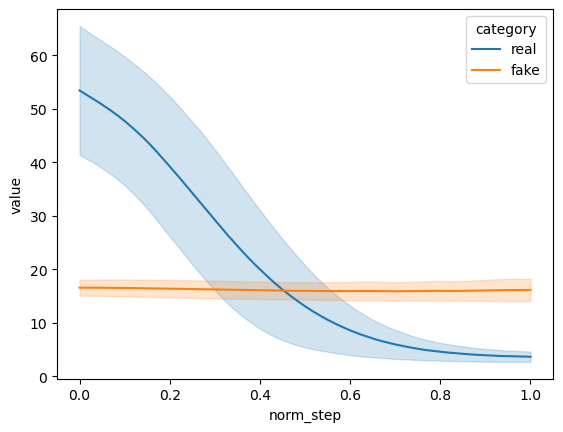

In [220]:
sns.lineplot(
    data=final,
    x="norm_step",
    y="value",
    hue="category",
    errorbar="sd",
)

In [3]:
datadir = Path("/scratch/ccmartin6/pst/data")
datafile = datadir.joinpath("esm2_t6_8M_results--filtered--GRAPHFMT.h5")
datafile.exists()

True

In [199]:
pd.DataFrame(summary)

,0,1,2,3
0,1,val_loss,7,49.242039
1,1,val_loss,15,48.775089
2,1,val_loss,23,48.318790
3,1,val_loss,31,47.873512
4,1,val_loss,39,47.438908
...,...,...,...,...
445,2,val_loss,1459,2.707267
446,2,val_loss,1469,2.704127
447,2,val_loss,1479,2.701407
448,2,val_loss,1489,2.680500


In [4]:
dataset = GenomeDataset(
    file=datafile,
    edge_strategy="chunked",
    chunk_size=30
)

In [12]:
torch.where(dataset.class_id == 4, 1, 0).sum()

tensor(67737)

In [15]:
class_counts = torch.bincount(dataset.class_id)
class_counts

tensor([21734, 10594,  2807,   717, 67737])

In [13]:
idx = torch.arange(len(dataset))
idx.shape

torch.Size([103589])

In [14]:
group = dataset.class_id

In [31]:
gkfold = GroupKFold(n_splits=len(class_counts))
folds = gkfold.split(X=idx, groups=group)
for i, (train_idx, val_idx) in enumerate(folds):
    train_classes = group[train_idx]
    val_classes = group[val_idx]

    train_class_counts = Counter(train_classes.tolist())
    val_class_counts = list(Counter(val_classes.tolist()).items())[0]
    print(f"Fold: {i}")
    print("\tTrain:")
    for k, v in train_class_counts.items():
        print(f"\t\tClass: {k}\tCount: {v}")
    
    k, v = val_class_counts
    print(f"\tValidation:\n\t\tClass: {k}\tCount: {v}")


Fold: 0
	Train:
		Class: 0	Count: 21734
		Class: 1	Count: 10594
		Class: 2	Count: 2807
		Class: 3	Count: 717
	Validation:
		Class: 4	Count: 67737
Fold: 1
	Train:
		Class: 1	Count: 10594
		Class: 2	Count: 2807
		Class: 3	Count: 717
		Class: 4	Count: 67737
	Validation:
		Class: 0	Count: 21734
Fold: 2
	Train:
		Class: 0	Count: 21734
		Class: 2	Count: 2807
		Class: 3	Count: 717
		Class: 4	Count: 67737
	Validation:
		Class: 1	Count: 10594
Fold: 3
	Train:
		Class: 0	Count: 21734
		Class: 1	Count: 10594
		Class: 3	Count: 717
		Class: 4	Count: 67737
	Validation:
		Class: 2	Count: 2807
Fold: 4
	Train:
		Class: 0	Count: 21734
		Class: 1	Count: 10594
		Class: 2	Count: 2807
		Class: 4	Count: 67737
	Validation:
		Class: 3	Count: 717


In [33]:
class_counts

tensor([21734, 10594,  2807,   717, 67737])

In [57]:
uniq_classes, class_counts = torch.unique(dataset.class_id, return_counts=True)
uniq_classes, class_counts

(tensor([0, 1, 2, 3, 4]), tensor([21734, 10594,  2807,   717, 67737]))

In [60]:
_uniq_classes = torch.arange(uniq_classes.numel())
if not torch.all(_uniq_classes == uniq_classes):
    uniq_classes = _uniq_classes

tensor(True)

In [61]:
argmax = torch.argmax(class_counts)
max_class_id = uniq_classes[argmax]
max_class_id

tensor(4)

In [58]:
torch.unique(torch.arange(0, 10, 2))

tensor([0, 2, 4, 6, 8])

In [88]:
Int64Array = NDArray[np.int64]
LongArray = Int64Array | torch.Tensor
class ImbalancedGroupKFold:
    def __init__(self, groups: LongArray, return_torch: bool = True) -> None:
        self.X_idx = self.get_X_index(groups, return_torch)

        self.uniq_groups: Int64Array
        self.groups: Int64Array
        # self.groups maps actual group labels to consecutively increasing,
        # ie [0, 1, ..., n-1, n]
        self.uniq_groups, self.groups = np.unique(groups, return_inverse=True)
        self.group_counts = np.bincount(self.groups)
        self._sort_groups()

        # don't have a fold for the most frequent group
        self.n_folds = self.uniq_groups.shape[0] - 1
        self.largest_group_id = np.argmax(self.group_counts)

    def get_X_index(self, groups: LongArray, return_torch: bool = True) -> LongArray:
        n = groups.shape[0]
        if return_torch:
            return torch.arange(n)
        return np.arange(n)
        
    def _sort_groups(self):
        # reverse sort, ie 0th element is count of most frequent group
        sort_idx = np.argsort(self.group_counts)[::-1]
        self.uniq_groups = self.uniq_groups[sort_idx]
        self.group_counts = self.group_counts[sort_idx]

    def __len__(self) -> int:
        return self.n_folds
    
    def split(self) -> Iterator[tuple[LongArray, LongArray]]:
        for fold_idx, group_id in enumerate(self.uniq_groups):
            if fold_idx == 0:
                # the first group will be the most frequent and
                # we don't want a fold where teh most frequent group
                # is the validation set
                continue

            val_mask = np.where(self.groups == group_id, True, False)
            train_mask = ~val_mask

            train_idx = self.X_idx[train_mask]
            val_idx = self.X_idx[val_mask]
            yield train_idx, val_idx
    
igkf = ImbalancedGroupKFold(dataset.class_id)

In [99]:
train_idx: torch.Tensor
val_idx: torch.Tensor
for fold_idx, (train_idx, val_idx) in enumerate(igkf.split()): # type: ignore
    # training loop
    n_train = train_idx.shape[0]
    n_val = val_idx.shape[0]
    total = n_train + n_val
    val_group_id = dataset.class_id[val_idx]
    train_group_ids = torch.unique(dataset.class_id[train_idx])
    train_group_counts = class_counts[train_group_ids]
    print(fold_idx, n_train, n_val, total, train_group_ids, train_group_counts, train_group_counts.sum(), val_group_id[0].item())

0 81855 21734 103589 tensor([1, 2, 3, 4]) tensor([10594,  2807,   717, 67737]) tensor(81855) 0
1 92995 10594 103589 tensor([0, 2, 3, 4]) tensor([21734,  2807,   717, 67737]) tensor(92995) 1
2 100782 2807 103589 tensor([0, 1, 3, 4]) tensor([21734, 10594,   717, 67737]) tensor(100782) 2
3 102872 717 103589 tensor([0, 1, 2, 4]) tensor([21734, 10594,  2807, 67737]) tensor(102872) 3


In [103]:
train_idx: torch.Tensor
val_idx: torch.Tensor
train_idx, val_idx = next(igkf.split()) # type: ignore
train_idx.shape

torch.Size([81855])

In [130]:
dataloader = DataLoader(
    dataset=TensorDataset(train_idx),
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: torch.tensor([i[0] for i in x])
)

classes: list[list[int]] = [
    dataset.class_id[batch].tolist()
    for batch in dataloader
]

In [152]:
class_counts

tensor([21734, 10594,  2807,   717, 67737])

In [ ]:
class ImbalancedCVDataModule(L.LightningDataModule):
    def __init__(self, ) -> None:
        super().__init__()

In [153]:
x = [
    torch.tensor(0),
    torch.tensor(1),
    torch.tensor(2)
]
x

[tensor(0), tensor(1), tensor(2)]

In [155]:
torch.stack(x)

tensor([0, 1, 2])

In [156]:
x = [
    torch.arange(0, 3),
    torch.arange(3, 6),
    torch.arange(6, 9)
]
x

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8])]

In [157]:
torch.stack(x)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])